<a href="https://colab.research.google.com/github/pulindu-seniya-silva/Fake-News-Detection-NLP/blob/main/Fake_News_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#installing NLTK for text preprocessing
!pip install nltk


In [3]:
 #install Hugging Face 'transformers' library for BERT/deep Learning
!pip install transformers

# Loading the dataset

In [4]:

#Data Manipulation and Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Mount Google Drive (if the file is there)
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/fake_news_dataset.csv'

df = pd.read_csv(file_path)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                  title  \
0               Foreign Democrat final.   
1   To offer down resource great point.   
2          Himself church myself carry.   
3                  You unit its should.   
4  Billion believe employee summer how.   

                                                text        date    source  \
0  more tax development both store agreement lawy...  2023-03-10  NY Times   
1  probably guess western behind likely next inve...  2022-05-25  Fox News   
2  them identify forward present success risk sev...  2022-09-01       CNN   
3  phone which item yard Republican safe where po...  2023-02-07   Reuters   
4  wonder myself fact difficult course forget exa...  2023-04-03       CNN   

                 author    category label  
0          Paula George    Politics  real  
1           Joseph Hill    Politics  fake  
2        Ju

In [5]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [6]:
#import libraries
#Natural Language Processing (Text Cleaning and Preprocessing)
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Machine Learning (Feature Extraction and Models)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Downloard NLTK resources
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Preliminary Data Inspection

In [7]:
#Check the total number of rows and columns
print(f"\nTotal rows and columns: {df.shape}")


Total rows and columns: (20000, 7)


In [8]:
#Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
title          0
text           0
date           0
source      1000
author      1000
category       0
label          0
dtype: int64


# imputation (Handling Missing Vlaues)

In [9]:
#Fill Nan values in 'author' and 'source' columns with 'Unknow'
df['author'] = df['author'].fillna('Unknow')
df['source'] = df['source'].fillna('Unknow')

#Re-check for nulls to confirm
print("\nMissing values after imputation:")
print(df.isnull().sum)


Missing values after imputation:
<bound method DataFrame.sum of        title   text   date  source  author  category  label
0      False  False  False   False   False     False  False
1      False  False  False   False   False     False  False
2      False  False  False   False   False     False  False
3      False  False  False   False   False     False  False
4      False  False  False   False   False     False  False
...      ...    ...    ...     ...     ...       ...    ...
19995  False  False  False   False   False     False  False
19996  False  False  False   False   False     False  False
19997  False  False  False   False   False     False  False
19998  False  False  False   False   False     False  False
19999  False  False  False   False   False     False  False

[20000 rows x 7 columns]>


# Feature Selection

In [10]:
#Combine 'title' and 'text' into a single 'full_text' feature
#using a space (' ') as separator
df['full_text'] = df['title'] + ' ' + df['text']

#Map the 'label' column from text ('fake', 'real') to numbers (1,0)
#This is crucial for machine learning models
df['label'] = df['label'].map({'fake': 1, 'real': 0})

#Display the result
print("\nDataFrame after combining text and mapping label:")
print(df[['full_text', 'label']].head())



DataFrame after combining text and mapping label:
                                           full_text  label
0  Foreign Democrat final. more tax development b...      0
1  To offer down resource great point. probably g...      1
2  Himself church myself carry. them identify for...      1
3  You unit its should. phone which item yard Rep...      1
4  Billion believe employee summer how. wonder my...      1


# Exploratory Data Analysis(EDA)- Class Imbalance

In [11]:
#Check the distribution of the target variable ('label')
print("\nDistribution of News Labels (0=Real, 1=Fake):")
print((df['label']).value_counts())


Distribution of News Labels (0=Real, 1=Fake):
label
1    10056
0     9944
Name: count, dtype: int64


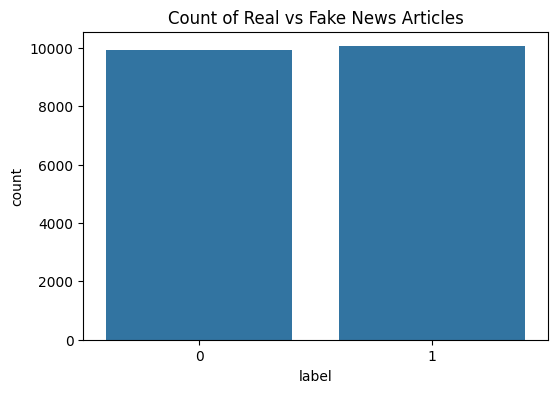

In [12]:
#visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Count of Real vs Fake News Articles')
plt.show()

# Text Preprocessing and Tokenization

In [13]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Define the Cleaning function
# we rely on the TfidVectorizer's built-in 'stop_words' functionality later,
# so we only perform essential cleaning here.

def clean_text(text):
  #convert text to lowercase
  text = text.lower()

  # Remove special characters, numbers, and punctuation (keep only letters and spaces)
  # Replace anything that is NOT a letter or a space with a single space
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)

  # Replace multiple spaces with a single space and trim surrounding whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  # Filter out single-character word (like 'a' or 'i' if they somehow survived stop word removal)
  words = [word for word in text.split() if len(word) > 1]

  return ' '.join(words)

# Apply the cleaning function to the 'full_text' column
df['cleaned_text'] = df['full_text'].apply(clean_text)

print("--- Text Cleaning Applied ---")
print(f"Original Text Sample: {df['full_text'].iloc[0][:100]}...")
print(f"Cleaned Text Sample: {df['cleaned_text'].iloc[0][:100]}...")




--- Text Cleaning Applied ---
Original Text Sample: Foreign Democrat final. more tax development both store agreement lawyer hear outside continue reach...
Cleaned Text Sample: foreign democrat final more tax development both store agreement lawyer hear outside continue reach ...


# Data Splitting (Train-Test Split)

In [14]:
X = df['cleaned_text']
y = df['label']

# Split the data, ensuring the label distribution is maintained (stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- Data Splitting Complete ---")
print(f"Total sample: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}\n")



--- Data Splitting Complete ---
Total sample: 20000
Training samples: 16000
Testing samples: 4000



# Feature Engineering (TF-IDF Vectorization)

In [15]:
# 1. Intialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.7,  # Ignore terms that appear in more than 70% of documents (too common)
    min_df=5,    # Ignore terms that appear in less than 5 documents (too rare/noise)
    ngram_range=(1, 2), # Use single words (unigrams) AND two-word phrases (bigrams)
    stop_words='english' # Use Scikit-learn's built-in stop word list
)




In [16]:
# 2. Fit and Transform (CRITICAL step: Fit only on Training Data!)
# .fit() learns the vocabulary from X_train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


In [18]:
# 3. Transform (Apply the vocabulary learned from X_train to the test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
print("--- TF-IDF Vectorization Complete ---")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"Vocabulary size (number of features): {len(tfidf_vectorizer.get_feature_names_out())}")

--- TF-IDF Vectorization Complete ---
X_train_tfidf shape: (16000, 374515)
X_test_tfidf shape: (4000, 374515)
Vocabulary size (number of features): 374515


# Model Development and Training

In [20]:
from sklearn.linear_model import PassiveAggressiveClassifier

# 1. Initialize the Model
# 'max_iter' is how many times the model scans the data (50 is usually enough)
# 'random_state' ensures you and I get the same results
pac_model = PassiveAggressiveClassifier(max_iter=50, random_state=42)

# 2. Training (The Learning Step)
# We give it the training features (X) and the correct answers (y)
pac_model.fit(X_train_tfidf, y_train)

print("Training Complete! The model has finished learning from the 16,000 articles.")

Training Complete! The model has finished learning from the 16,000 articles.


# Testing and Evaluation

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Predict (The "Exam" Step)
# We ask the model to guess the labels for the unseen test data
y_pred = pac_model.predict(X_test_tfidf)

# 2. Calculate Accuracy
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100, 2)}%')

# 3. Create the Confusion Matrix
# This shows: [ [True Positives, False Negatives], [False Positives, True Negatives] ]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 4. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 50.68%

Confusion Matrix:
[[ 993  996]
 [ 977 1034]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1989
           1       0.51      0.51      0.51      2011

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000

